In [573]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.options.mode.chained_assignment = None

In [621]:
round_order = {"Angel Round": 0, "Pre Seed Round": 1, "Seed Round": 2, "Series A": 3,
               "Series B": 4, "Series C": 5, "Series D": 6, "Series E": 7, "Series F": 8, "Series G": 9,
               "Series H": 10, "Series I": 11, "Series J": 12, "Venture Round": 25, "Grant": 26,
               "Private Equity Round": 13, "Debt Financing": 14, "Convertible Note": 15, "Non Equity Assistance": 16,
               "Post-IPO Equity": 17, "Funding Round": 18, "Corporate Round Equity Crowdfunding": 19,
               "Post-IPO Debt": 20, "Secondary Market": 21, "Initial Coin Offering": 22,
               "Post-IPO Secondary": 23, "Product Crowdfunding": 24}

In [539]:
midas = pd.read_csv("Midas Touch Dataset (Eduard).csv")
midas.round_created_at = pd.to_datetime(pd.to_datetime(midas.round_created_at).dt.date)
midas = midas.drop_duplicates(subset=["round_created_at", "round_name", "company_name", "investor_name"])
midas["round_order"] = midas.round_name.map(round_order)

## Initital data exploration

- The dataset describes 704,835 different investing events
- There are 102,625 different investors in the dataset
- There are 11,264 investors who made at least 10 different investments
- There are 6,100 investors who made at least  20 different investments
- There are 175,405 different companies in the dataset
- Out of all the companies, 94,442 had more than one investor

If we now tried to reparametrise this using a matrix, it will be huge (say 10k x 175k) - better to use a set approach or sparse matrix approach to evaluate the distance between each investor.

In [801]:
midas.head()

,round_created_at,funding_round_uuid,round_name,company_name,investor_name,round_order
0,2020-12-01,339c4396-3270-4d2f-a618-fcb2a236c91e,Series G,Olive,GV,9.0
1,2020-06-10,6dec5eba-b3fd-4590-a3a4-b7ec80e36e99,Series G,DNAnexus,GV,9.0
2,2021-09-09,af255f66-8f80-4047-b907-e0a5771e002b,Series F,SingleStore,GV,8.0
3,2019-02-07,e75d676a-b8cd-404d-a003-fe8314e16f78,Series F,DNAnexus,GV,8.0
4,2021-11-18,39ecbaf7-d9ff-49e0-b51a-21a03770975a,Series G,Farmer's Business Network,GV,9.0


In [802]:
midas.shape

(694792, 6)

In [803]:
midas.round_created_at.sort_values(ascending=False)

510892   2021-12-11
645584   2021-12-11
634376   2021-12-11
545915   2021-12-11
75058    2021-12-11
            ...    
127172   2007-05-31
173481   2007-05-29
117691   2007-05-27
225277   2007-05-27
209894   2007-05-27
Name: round_created_at, Length: 694792, dtype: datetime64[ns]

In [808]:
midas.investor_name.value_counts().shape

(102625,)

In [809]:
midas.company_name.value_counts().shape

(175405,)

In [804]:
midas.investor_name.value_counts().head()

Y Combinator                            4181
Techstars                               3514
EASME - EU Executive Agency for SMEs    3506
500 Startups                            2675
MassChallenge                           2643
Name: investor_name, dtype: int64

In [805]:
sum(midas.investor_name.value_counts() >= 10)

11173

In [806]:
sum(midas.company_name.value_counts() > 1)

93298

(array([1.70188e+05, 4.36100e+03, 6.78000e+02, 1.27000e+02, 3.10000e+01,
        1.30000e+01, 3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([  1. ,  19.5,  38. ,  56.5,  75. ,  93.5, 112. , 130.5, 149. ,
        167.5, 186. ]),
 <BarContainer object of 10 artists>)

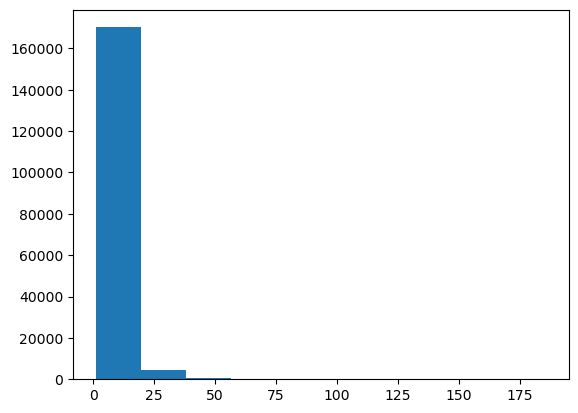

In [807]:
plt.hist(midas.company_name.value_counts())

## GOAL 1: Identify N nearest neighbours based on parameters

In [624]:
def invested_before(data, VC, invested_VC, investors, period):
    """Returns for every investor from 'investors' the list containing the names of the companies that
    that this investor invested in before the VC invested in them.
    
    Parameters:
    ----------
    data: pd.DataFrame
        Data containing informations about financing rounds that should be considered.
    VC: str
        Name of the VC that the function analyses.
    invested_VC: list
        A list of the names of the companies that the VC has invested in.
    investors: list
        A list of the names of the investors to be considered.
    period: str
        How detailed comparisons should be considered (e.g. "M" for month or "D" for day)
    """
    data = data.loc[data.company_name.isin(invested_VC)]
    
    time_VC_invested = data.loc[data.investor_name == VC].set_index("company_name").round_created_at
    round_order_VC = data.loc[data.investor_name == VC].set_index("company_name").round_order
    
    data["round_order_VC"] = data.company_name.map(round_order_VC)
    data["time_VC"] = data.company_name.map(time_VC_invested)
    data = data.loc[(data.round_created_at.dt.to_period(period) < data.time_VC.dt.to_period(period))
                    & (data.round_order <= data.round_order_VC)].copy()

    inv_before = [list(data.loc[data.investor_name == i].company_name.unique()) for i in investors]
    
    return inv_before


def invested_after(data, VC, invested_VC, investors, period):
    """Returns for every investor from 'investors' the list containing the names of the companies that
    that this investor invested in after the VC invested in them.
    
    Parameters:
    ----------
    data: pd.DataFrame
        Data containing informations about financing rounds that should be considered.
    VC: str
        Name of the VC that the function analyses.
    invested_VC: list
        A list of the names of the companies that the VC has invested in.
    investors: list
        A list of the names of the investors to be considered.
    period: str
        How detailed comparisons should be considered (e.g. "M" for month or "D" for day)
    """
    #considering only the companies that VC invested in
    data = data.loc[data.company_name.isin(invested_VC)]
    
    time_VC_invested = data.loc[data.investor_name == VC].set_index("company_name").round_created_at
    round_order_VC = data.loc[data.investor_name == VC].set_index("company_name").round_order
    
    data["round_order_VC"] = data.company_name.map(round_order_VC)
    data["time_VC"] = data.company_name.map(time_VC_invested)
    data = data.loc[(data.round_created_at.dt.to_period(period) > data.time_VC.dt.to_period(period))
                    & (data.round_order >= data.round_order_VC)].copy()

    inv_after = [list(data.loc[data.investor_name == i].company_name.unique()) for i in investors]
    
    return inv_after



def invested_together(data, VC, invested_VC, investors):
    """Returns for every investor from 'investors' the list containing the names of the companies that
    that this investor invested in the same round that VC invested in it.
    
    Parameters:
    ----------
    data: pd.DataFrame
        Data containing informations about financing rounds that should be considered.
    VC: str
        Name of the VC that the function analyses.
    invested_VC: list
        A list of the names of the companies that the VC has invested in.
    investors: list
        A list of the names of the investors to be considered.
    """
    #considering only the companies that VC invested in
    data = data.loc[data.company_name.isin(invested_VC)]
    
    round_VC_invested = data.loc[data.investor_name == VC].set_index("company_name").round_name
    
    data["round_VC"] = data.company_name.map(round_VC_invested)
    data = data.loc[data.round_name == data.round_VC].copy()

    inv_together = [list(data.loc[data.investor_name == i].company_name.unique()) for i in investors]
    
    return inv_together



def invested_together_df(VC1, VC2, financing_round="default",
                         sequence_of_investments="any", time_scale=(),
                         period="D"):
    """Returns for the pair of investors VC1 and VC2 the list of common investments matching
    the specified criteria.
    
    Parameters:
    ----------
    VC1: str
        Name of the first VC that the function analyses.
    VC: str
        Name of the second VC that the function analyses.
    financing_round: list or "all" or "default"
        List including the name of all the financing rounds that are of interest.
        If "all": all financing rounds will be considered.
        If "default": consider only Angel + pre-seed + seed + Series A-J
    sequence_of_investments: "any", "before", or "after"
        If "any": all co-investment events will be considered.
        If "before": only investments in a given company made before the VC invested will be considered.
        If "after": only investments in a given company made after the VC invested will be considered.
        If "together": only investments in a given company made in the same investment round will be consiered.
    time_scale: tuple (start_date, end_date), () or str
        If (): all available data will be used.
        If tuple: only investments made in the period from start_date to end_date will be considered.
            Note: start_date and end_date need to have format pd.to_datetime("YYYY-MM-DD")
        If str: string of the from "2Y" where the the number indicates how far back we want to consider
            and the letter indicates the unit (can be "M" for months or "Y" for years).
    period: str
        How detailed comparisons should be considered (e.g. "M" for month or "D" for day)
    """
    data = midas
    
    #consider only the investments made by VC1 and VC2
    data = data.loc[data.investor_name.isin([VC1, VC2])]
    
    if financing_round != "all":
        if financing_round == "default":
            financing_round=["Angel Round", "Pre Seed Round", "Seed Round", "Series A",
               "Series B", "Series C", "Series D", "Series E", "Series F", "Series G",
               "Series H", "Series I", "Series J"]
        data = data.loc[data.round_name.isin(financing_round)]
    
    
    if time_scale:
        if type(time_scale) == str:
            n = int(time_scale[0])
            end_date = datetime.date.today()
            start_date = end_date - datetime.timedelta(days=365*n)
        elif type(time_scale) == tuple:
            (start_date, end_date) = time_scale
        else:
            raise Exception("Wrong time_scale format.")
            
        data = data.loc[(data.round_created_at >= pd.to_datetime(start_date))
                        & (data.round_created_at <= pd.to_datetime(end_date))]
    
    # consider only the first time each VC invested in a given company
    data = data.sort_values(by=["round_created_at", "round_order"]).drop_duplicates(subset=["investor_name", "company_name"])

    invested_VC1 = list(data.loc[data.investor_name == VC1].company_name.unique())
    invested_VC2 = list(data.loc[data.investor_name == VC2].company_name.unique())

    
    if not invested_VC1:
        raise Exception(f"{VC1} made no investments matching the criteria.")
    if not invested_VC2:
        raise Exception(f"{VC2} made no investments matching the criteria.")
    
    # finding common investments under the given criteria
    if sequence_of_investments == "any":
        invested_VC1_df = data.loc[(data.investor_name == VC1)
                                   & (data.company_name.isin(invested_VC2))].set_index("company_name")[["round_name", "round_created_at"]]
        invested_VC2_df = data.loc[(data.investor_name == VC2)
                                   & (data.company_name.isin(invested_VC1))].set_index("company_name")[["round_name", "round_created_at"]]
        
        return invested_VC1_df.join(invested_VC2_df, lsuffix=f"_{VC1}", rsuffix=f"_{VC2}")
    
    elif sequence_of_investments == "before":
        # find companies where VC2 invested before VC1
        invested_list = invested_before(data, VC1, invested_VC1, [VC2], period)[0]
        
        invested_VC1_df = data.loc[(data.investor_name == VC1)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        invested_VC2_df = data.loc[(data.investor_name == VC2)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        
        return invested_VC1_df.join(invested_VC2_df, lsuffix=f"_{VC1}", rsuffix=f"_{VC2}")
        
    elif sequence_of_investments == "after":
        # find companies where VC2 invested after VC1
        invested_list = invested_after(data, VC1, invested_VC1, [VC2], period)[0]
        
        invested_VC1_df = data.loc[(data.investor_name == VC1)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        invested_VC2_df = data.loc[(data.investor_name == VC2)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        
        return invested_VC1_df.join(invested_VC2_df, lsuffix=f"_{VC1}", rsuffix=f"_{VC2}")
    
    elif sequence_of_investments == "together":
        # find companies where VC2 and VC1 invested in the same round
        invested_list = invested_together(data, VC1, invested_VC1, [VC2])[0]
        
        invested_VC1_df = data.loc[(data.investor_name == VC1)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        invested_VC2_df = data.loc[(data.investor_name == VC2)
                                   & (data.company_name.isin(invested_list))].set_index("company_name")[["round_name", "round_created_at"]]
        
        return invested_VC1_df.join(invested_VC2_df, lsuffix=f"_{VC1}", rsuffix=f"_{VC2}")
    
    else:
        raise Exception(f"Unknown sequence of investments: {sequence_of_investments}")


In [810]:
def n_nearest_neighbours(VC, n=10, financing_round="default",
                         sequence_of_investments="any", time_scale=(),
                         similarity="jacc", min_no_inv=50, period="D",
                         round_scale="default", sim_func="default", investors_list=()):
    """Finds N most similar investors to V under the specified constraints.
    
    Parameters:
    ----------
    VC: str
        The name of the VC for which neighbours are to be computed.
    N: int
        The number of nearest neighbours to be computed.
    financing_round: list or "all" or "default"
        List including the name of all the financing rounds that are of interest.
        If "all": all financing rounds will be considered.
        If "default": consider only Angel + pre-seed + seed + Series A-J
    sequence_of_investments: "any", "before", or "after"
        If "any": all co-investment events will be considered.
        If "before": only investments in a given company made before the VC invested will be considered.
        If "after": only investments in a given company made after the VC invested will be considered.
        If "together": only investments in a given company made in the same investment round will be consiered.
    time_scale: tuple (start_date, end_date), () or str
        If (): all available data will be used.
        If tuple: only investments made in the period from start_date to end_date will be considered.
            Note: start_date and end_date need to have format pd.to_datetime("YYYY-MM-DD")
        If str: string of the from "2Y" where the the number indicates how far back we want to consider
            and the letter indicates the unit (can be "M" for months or "Y" for years).
    similarity: str or list
        If str:
            Function used to compute the similarity between investors.
                - "jacc": jaccard similarity
                - "cond": conditional probability-based similarity
                - "abs": total number of co-investments made
                - "round_sim": similarity which is inversly proportional to the distance between the
                    investment rounds specified using 'round_scale'
        If list:
            A list specifying which of the above should be computed and displayed together (sorted by the
            first used measure).
    min_no_inv: int
        Only consider investors which made at least that many investments in the specified period.
    period: str
        Period to be used with the pd.dt.to_period() function to specify the granularity of the comparisons
        between the times of investments.
    round_scale: dict
        Dictionary mapping financing rounds to the number line, outlining how the distance
        between different financing rounds should be calculated.
    sim_func: function
        The function used to convert the distance into a similarity measure on a [0, 1] interval when using
        round similarity as a similarity measure.
    investors_list: list or ()
        If (): consider all the investors in the dataset
        Otherwise: only consider the similarity between the VC and the investors in the list
    """
    data = midas
    
    if financing_round != "all":
        if financing_round == "default":
            financing_round=["Angel Round", "Pre Seed Round", "Seed Round", "Series A",
               "Series B", "Series C", "Series D", "Series E", "Series F", "Series G",
               "Series H", "Series I", "Series J"]
        data = data.loc[data.round_name.isin(financing_round)]
    
    if round_scale == "default":
        round_scale = {"Angel Round": 0, "Pre Seed Round": 1, "Seed Round": 2, "Series A": 6,
               "Series B": 12, "Series C": 13, "Series D": 14, "Series E": 15, "Series F": 16, "Series G": 17,
               "Series H": 18, "Series I": 19, "Series J": 20}
    
    if sim_func == "default":
        def sim_func(x):
            return(1/(1+x))
    
    if time_scale:
        if type(time_scale) == str:
            y = int(time_scale[0])
            end_date = datetime.date.today()
            start_date = end_date - datetime.timedelta(days=365*y)
        elif type(time_scale) == tuple:
            (start_date, end_date) = time_scale
        else:
            raise Exception("Wrong time_scale format.")
            
        data = data.loc[(data.round_created_at >= pd.to_datetime(start_date)) & (data.round_created_at <= pd.to_datetime(end_date))]
    
    if investors_list:
        data = data.loc[data.investor_name.isin(investors_list)]
    
    # consider only the first time each VC invested in a given company
    data = data.sort_values(by=["round_created_at", "round_order"]).drop_duplicates(subset=["investor_name", "company_name"])
    
    #list all the investors and companies they invested in
    investors = np.array(data.groupby('investor_name').filter(lambda x: len(x) >= min_no_inv).investor_name.unique())
    investors = investors[investors != VC]
    
    invested_VC = list(data.loc[data.investor_name == VC].company_name.unique())
    invested_others = [list(data.loc[data.investor_name == u].company_name.unique()) for u in investors]
    
    if not invested_VC:
        raise Exception(f"{VC} made no investments matching the criteria.")

    
    # finding common investments under the given criteria
    if sequence_of_investments == "any":
        invested_list = [list(set(invested_others[i]) & set(invested_VC)) for i in range(len(investors))]
    
    elif sequence_of_investments == "before":
        # the first round from VC is after some round from the other investor
        invested_list = invested_before(data, VC, invested_VC, investors, period)
        
    elif sequence_of_investments == "after":
        # the first round from the other investor is after the first round from VC
        invested_list = invested_after(data, VC, invested_VC, investors, period)
    
    elif sequence_of_investments == "together":
        # the first round from the other investor is the same as the first round from VC
        invested_list = invested_together(data, VC, invested_VC, investors)
    else:
        raise Exception(f"Unknown sequence of investments: {sequence_of_investments}")
    
    #computing similarities
    no_investments = [len(data.loc[data.investor_name == investor].company_name.unique())
                      for investor in investors]
    sim_df = pd.DataFrame({"total_no_investments": no_investments}, index=investors)

    
    if type(similarity) == str:
        similarity = [similarity]
        
    ind = 1
    
    for sim in similarity:
        if sim == "jacc":
            sim_vector = [len(invested_list[i])/len(set(invested_VC) | set(invested_others[i]))
                          for i in range(len(investors))]
    
        elif sim == "cond":
            if sequence_of_investments == "any":
                # conditional probability that a given investor invested, given that VC invested
                sim_vector = [len(invested_list[i])/len(invested_others[i]) for i in range(len(investors))]
            elif sequence_of_investments == "before":
                # conditional probability that VC invested given that given investor invested before
                sim_vector = [len(invested_list[i])/len(invested_others[i]) for i in range(len(investors))]
            elif sequence_of_investments == "after":
                # conditional probability that a given investor invested after the VC
                sim_vector = [len(invested_list[i])/len(invested_VC) for i in range(len(investors))]
            elif sequence_of_investments == "together":
                # conditional probability that VC invested together with a given investor,
                # given that this other investor invested
                sim_vector = [len(invested_list[i])/len(invested_others[i]) for i in range(len(investors))]
        
        elif sim == "abs":
            # count number of times that they invested together (or before/after)
            sim_vector = [len(invested_list[i]) for i in range(len(investors))]
        
        elif sim == "round_sim":
            data["round_scale"] = data.round_name.map(round_scale)
            invested_VC_df = data.loc[data.investor_name == VC]
            sim_vector = np.zeros(len(investors))
        
            for i in range(len(investors)):
                if len(invested_list[i]) == 0:
                    sim_vector[i] = 0
                else:
                    together = data.loc[data.company_name.isin(invested_list[i]) & (data.investor_name == investors[i])]
                    together = together.set_index("company_name").join(invested_VC_df.set_index("company_name"), rsuffix="_VC")
            
                    #round similarity between investments, when two companies invested together
                    sim_vector[i] = sum(sim_func(abs(np.array(together.round_scale - together.round_scale_VC))))/len(invested_VC)
        else:
            raise Exception(f"Unknown similarity function: {sim}.")
        
        new_sim_df = pd.DataFrame({sim: sim_vector}, index=investors)
        sim_df = sim_df.join(new_sim_df)
        
        if ind == 1:
            sim_df = sim_df.sort_values(by=similarity[0], ascending=False).head(n)
            investors_top = list(sim_df.index)
            invested_list = [invested_list[list(investors).index(x)] for x in investors_top]
            invested_others = [invested_others[list(investors).index(x)] for x in investors_top]
            investors = investors_top.copy()
            
            ind += 1

    return sim_df

### Testing validation cases

In [811]:
n_nearest_neighbours("Y Combinator", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Soma Capital,215,24,0.111628,0.009572
FAST — by GETTYLAB,60,23,0.383333,0.009970
Techstars,2348,19,0.008092,0.006068
Liquid 2 Ventures,196,14,0.071429,0.005202
500 Startups,822,14,0.017032,0.005263
ACE & Company,100,13,0.130000,0.003154
AltaIR Capital,158,11,0.069620,0.002290
FundersClub,146,10,0.068493,0.003941
Louis Beryl,87,8,0.091954,0.001639
Khosla Ventures,254,7,0.027559,0.002446


In [863]:
n_nearest_neighbours("Y Combinator", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y").index[1]

'FAST —\xa0by GETTYLAB'

In [840]:
n_nearest_neighbours("Y Combinator", sequence_of_investments='together', similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Soma Capital,215,105,0.488372,0.045514
FundersClub,146,80,0.547945,0.034677
Pioneer Fund,104,79,0.759615,0.034244
Liquid 2 Ventures,196,78,0.397959,0.033810
SV Angel,452,56,0.123894,0.024274
AltaIR Capital,158,42,0.265823,0.018205
Global Founders Capital,350,40,0.114286,0.017339
Initialized Capital,192,36,0.187500,0.015605
Khosla Ventures,254,34,0.133858,0.014738
FAST — by GETTYLAB,60,33,0.550000,0.014304


In [841]:
n_nearest_neighbours("Y Combinator", sequence_of_investments='after', similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Soma Capital,215,90,0.039012,0.032636
Pioneer Fund,104,86,0.037278,0.033069
FundersClub,146,72,0.031209,0.027389
Liquid 2 Ventures,196,64,0.027742,0.021446
SV Angel,452,60,0.026008,0.019119
Global Founders Capital,350,42,0.018205,0.013936
AltaIR Capital,158,41,0.017772,0.016403
MAGIC Fund,79,39,0.016905,0.014160
VentureSouq,76,39,0.016905,0.014149
Initialized Capital,192,37,0.016038,0.011606


In [812]:
invested_together_df("Y Combinator", "Soma Capital", sequence_of_investments="before", time_scale="5Y")

,round_name_Y Combinator,round_created_at_Y Combinator,round_name_Soma Capital,round_created_at_Soma Capital
company_name,,,,
Shield Bio,Seed Round,2019-08-28,Seed Round,2019-07-14
Ironclad,Series C,2019-09-17,Seed Round,2019-07-13
PayMongo,Seed Round,2019-10-28,Seed Round,2019-09-25
yearend.,Seed Round,2020-04-06,Seed Round,2020-03-30
Explo,Seed Round,2020-04-06,Seed Round,2020-03-30
Cadence,Seed Round,2020-04-06,Seed Round,2020-03-30
Bego,Seed Round,2020-04-06,Seed Round,2020-03-30
ZeoAuto,Seed Round,2020-04-06,Seed Round,2020-03-30
goDutch,Seed Round,2020-04-06,Seed Round,2020-03-30


In [855]:
n_nearest_neighbours("GV", sequence_of_investments="after", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Casdin Capital,100,10,0.037736,0.020485
SoftBank Vision Fund,199,9,0.033962,0.011803
BlackRock,75,8,0.030189,0.008783
Temasek Holdings,154,7,0.026415,0.010451
Fidelity Management and Research Company,107,7,0.026415,0.014465
RA Capital Management,129,6,0.022642,0.005863
Invus,72,6,0.022642,0.010445
Tiger Global Management,387,5,0.018868,0.008491
T. Rowe Price,99,5,0.018868,0.006954
Cormorant Asset Management,95,5,0.018868,0.005323


In [814]:
n_nearest_neighbours("Goldman Sachs", sequence_of_investments="after", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
SoftBank Vision Fund,199,7,0.044872,0.022866
Tiger Global Management,387,3,0.019231,0.006054
Sand Hill Angels,222,3,0.019231,0.009615
Alumni Ventures,601,3,0.019231,0.010531
GS Growth,57,2,0.012821,0.006410
CICC,77,2,0.012821,0.009615
Salesforce Ventures,194,2,0.012821,0.012821
Spark Capital,130,2,0.012821,0.009615
Coatue,176,2,0.012821,0.005342
Kleiner Perkins,207,2,0.012821,0.009615


### Testing interesting cases

In [843]:
n_nearest_neighbours("Sequoia Capital", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,16,0.006935,0.028298
Index Ventures,225,10,0.044444,0.011444
Sequoia Capital India,166,8,0.048193,0.009982
Techstars,2348,6,0.002555,0.008661
Tiger Global Management,387,6,0.015504,0.007348
Sequoia Capital China,499,6,0.012024,0.008672
Accel,341,5,0.014663,0.006533
Founders Fund,244,4,0.016393,0.006402
Elad Gil,65,4,0.061538,0.002091
Redpoint,109,4,0.036697,0.005589


In [844]:
n_nearest_neighbours("Sequoia Capital", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
SV Angel,452,14,0.030973,0.042683
Y Combinator,2307,11,0.004768,0.033537
Kevin Hartz,53,8,0.150943,0.024390
Andreessen Horowitz,313,8,0.025559,0.024390
Kleiner Perkins,207,8,0.038647,0.024390
Coatue,176,7,0.039773,0.021341
Index Ventures,225,7,0.031111,0.021341
Tiger Global Management,387,7,0.018088,0.021341
SoftBank Vision Fund,199,7,0.035176,0.021341
GV,265,6,0.022642,0.018293


In [845]:
n_nearest_neighbours("Sequoia Capital", sequence_of_investments="after", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Tiger Global Management,387,20,0.060976,0.020362
Coatue,176,14,0.042683,0.018902
Sequoia Capital India,166,8,0.024390,0.010953
GV,265,8,0.024390,0.008889
SoftBank Vision Fund,199,7,0.021341,0.011795
Dragoneer Investment Group,63,7,0.021341,0.006657
Baillie Gifford,58,7,0.021341,0.009678
SV Angel,452,6,0.018293,0.016260
Andreessen Horowitz,313,6,0.018293,0.007876
Franklin Templeton Investments,80,6,0.018293,0.006707


In [817]:
n_nearest_neighbours("Andreessen Horowitz", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,25,0.010837,0.023620
Kleiner Perkins,207,9,0.043478,0.009506
Founders Fund,244,8,0.032787,0.006988
Coatue,176,6,0.034091,0.011182
Accel,342,6,0.017544,0.006262
Sequoia Capital,328,6,0.018293,0.008253
GV,265,5,0.018868,0.007502
DST Global,102,5,0.049020,0.008253
Tiger Global Management,387,5,0.012920,0.007455
First Round Capital,145,5,0.034483,0.002125


In [818]:
n_nearest_neighbours("Andreessen Horowitz", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
SV Angel,452,25,0.055310,0.079872
GV,265,16,0.060377,0.051118
Y Combinator,2307,15,0.006502,0.047923
Abstract Ventures,114,15,0.131579,0.047923
Union Square Ventures,76,9,0.118421,0.028754
Alumni Ventures,601,9,0.014975,0.028754
Polychain,69,9,0.130435,0.028754
New Enterprise Associates,282,9,0.031915,0.028754
Coinbase Ventures,122,8,0.065574,0.025559
Sequoia Capital,328,8,0.024390,0.025559


In [819]:
n_nearest_neighbours("Accel", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,19,0.008236,0.032338
Bessemer Venture Partners,256,5,0.019531,0.004344
Sequoia Capital,328,5,0.015244,0.005152
Techstars New York City Accelerator,205,4,0.019512,0.009038
Slow Ventures,194,4,0.020619,0.006601
The Family,53,3,0.056604,0.001035
ACE & Company,100,3,0.030000,0.000935
Index Ventures,225,3,0.013333,0.003190
Coatue,176,3,0.017045,0.006579
Creandum,51,3,0.058824,0.001420


In [820]:
n_nearest_neighbours("Accel", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,23,0.009970,0.067251
GV,265,13,0.049057,0.038012
General Catalyst,288,9,0.031250,0.026316
Tiger Global Management,387,9,0.023256,0.026316
Chiratae Ventures,65,9,0.138462,0.026316
Sequoia Capital India,166,8,0.048193,0.023392
Salesforce Ventures,194,8,0.041237,0.023392
Insight Partners,291,8,0.027491,0.023392
Index Ventures,225,8,0.035556,0.023392
Bessemer Venture Partners,256,6,0.023438,0.017544


In [821]:
n_nearest_neighbours("Bill Gates", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Khosla Ventures,254,2,0.007874,0.054422
Alexandria Venture Investments,120,1,0.008333,0.047619
Accel,342,1,0.002924,0.047619
Polaris Partners,108,1,0.009259,0.047619
Two Sigma Ventures,59,1,0.016949,0.047619
Lux Capital,133,1,0.007519,0.047619
Temasek Holdings,154,1,0.006494,0.006803
Sinovation Ventures,128,1,0.007812,0.047619
Intel Capital,190,1,0.005263,0.047619
FJ Labs,349,1,0.002865,0.047619


In [822]:
n_nearest_neighbours("Bill Gates", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Lux Capital,133,4,0.030075,0.190476
Khosla Ventures,254,3,0.011811,0.142857
Kleiner Perkins,207,2,0.009662,0.095238
Temasek Holdings,154,2,0.012987,0.095238
IndieBio,114,1,0.008772,0.047619
Revolution’s Rise of the Rest Seed Fund,148,1,0.006757,0.047619
StartX (Stanford-StartX Fund),104,1,0.009615,0.047619
Polaris Partners,108,1,0.009259,0.047619
Tiger Global Management,387,1,0.002584,0.047619
SoftBank Vision Fund,199,1,0.005025,0.047619


In [823]:
n_nearest_neighbours("Sierra Ventures", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,4,0.001734,0.051913
Jump Capital,75,2,0.026667,0.006557
Soma Capital,215,2,0.009302,0.032787
Nexus Venture Partners,75,1,0.013333,0.016393
Redpoint,109,1,0.009174,0.016393
Brad Flora,58,1,0.017241,0.016393
Surge,83,1,0.012048,0.003279
Forum Ventures,109,1,0.009174,0.016393
Battery Ventures,126,1,0.007937,0.016393
Slow Ventures,194,1,0.005155,0.016393


In [824]:
n_nearest_neighbours("Sierra Ventures", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,4,0.001734,0.065574
Qualcomm Ventures,100,2,0.020000,0.032787
Battery Ventures,126,2,0.015873,0.032787
Khosla Ventures,254,2,0.007874,0.032787
Correlation Ventures,108,2,0.018519,0.032787
Cota Capital,68,2,0.029412,0.032787
Cisco,68,2,0.029412,0.032787
Soma Capital,215,2,0.009302,0.032787
Gaingels,265,2,0.007547,0.032787
Slow Ventures,194,2,0.010309,0.032787


In [825]:
n_nearest_neighbours("Y Combinator", sequence_of_investments="after", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Soma Capital,215,90,0.039012,0.032636
Pioneer Fund,104,86,0.037278,0.033069
FundersClub,146,72,0.031209,0.027389
Liquid 2 Ventures,196,64,0.027742,0.021446
SV Angel,452,60,0.026008,0.019119
Global Founders Capital,350,42,0.018205,0.013936
AltaIR Capital,158,41,0.017772,0.016403
VentureSouq,76,39,0.016905,0.014149
MAGIC Fund,79,39,0.016905,0.014160
Initialized Capital,192,37,0.016038,0.011606


In [856]:
n_nearest_neighbours("GV", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2307,9,0.003901,0.011727
Sequoia Capital,328,8,0.024390,0.011003
Alexandria Venture Investments,120,5,0.041667,0.008625
Slow Ventures,194,5,0.025773,0.010249
Kleiner Perkins,207,5,0.024155,0.007996
Andreessen Horowitz,313,4,0.012780,0.013208
ARCH Venture Partners,87,4,0.045977,0.006739
Canaan Partners,148,4,0.027027,0.006671
Index Ventures,225,4,0.017778,0.006954
CRV,115,4,0.034783,0.005606


In [857]:
n_nearest_neighbours("GV", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Casdin Capital,100,17,0.170000,0.064151
Kleiner Perkins,207,16,0.077295,0.060377
Andreessen Horowitz,313,16,0.051118,0.060377
Accel,341,13,0.038123,0.049057
General Catalyst,288,12,0.041667,0.045283
ARCH Venture Partners,87,12,0.137931,0.045283
Alexandria Venture Investments,120,10,0.083333,0.037736
New Enterprise Associates,279,9,0.032258,0.033962
F-Prime Capital,137,8,0.058394,0.030189
Polaris Partners,108,8,0.074074,0.030189


In [860]:
n_nearest_neighbours("Soma Capital", sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2306,105,0.045533,0.488372
Liquid 2 Ventures,196,36,0.183673,0.167442
Global Founders Capital,350,26,0.074286,0.120930
FundersClub,146,22,0.150685,0.102326
Justin Mateen,78,19,0.243590,0.088372
Pioneer Fund,104,13,0.125000,0.060465
Hack VC,72,12,0.166667,0.055814
VentureSouq,76,10,0.131579,0.046512
SV Angel,452,9,0.019912,0.041860
Initialized Capital,192,7,0.036458,0.032558


In [864]:
n_nearest_neighbours('FAST —\xa0by GETTYLAB', sequence_of_investments="together", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2306,33,0.014310,0.550000
Soma Capital,215,3,0.013953,0.050000
Techstars,2348,2,0.000852,0.033333
10X Capital,171,2,0.011696,0.033333
Village Global,160,1,0.006250,0.016667
Pioneer Fund,104,1,0.009615,0.016667
Tribe Capital,81,1,0.012346,0.016667
Fifty Years,58,1,0.017241,0.016667
MAGIC Fund,79,1,0.012658,0.016667
Susa Ventures,76,1,0.013158,0.016667


In [865]:
n_nearest_neighbours('FAST —\xa0by GETTYLAB', sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2306,11,0.004770,0.169444
Soma Capital,215,2,0.009302,0.033333
Techstars,2348,2,0.000852,0.033333
Matrix Partners,92,2,0.021739,0.019048
MAGIC Fund,79,1,0.012658,0.016667
Susa Ventures,76,1,0.013158,0.016667
GV,265,1,0.003774,0.002381
Global Founders Capital,350,1,0.002857,0.003333
TheVentureCity - First Ticket,59,1,0.016949,0.016667
Startupbootcamp,125,1,0.008000,0.016667


In [862]:
n_nearest_neighbours("Soma Capital", sequence_of_investments="before", similarity=["abs", "cond", "round_sim"], time_scale="5Y")

,total_no_investments,abs,cond,round_sim
Y Combinator,2306,90,0.039029,0.350190
FundersClub,146,9,0.061644,0.041860
Justin Mateen,78,7,0.089744,0.032558
Liquid 2 Ventures,196,7,0.035714,0.027907
Pioneer Fund,104,5,0.048077,0.020930
Louis Beryl,87,5,0.057471,0.023256
SV Angel,452,4,0.008850,0.018605
Streamlined Ventures,77,3,0.038961,0.009819
BoxGroup,192,3,0.015625,0.011628
ACE & Company,100,3,0.030000,0.013953


## Goal 2: Plotting the map of nearest neighbours 

In [826]:
import networkx as nx
import matplotlib as mpl
from sklearn.manifold import MDS

In [847]:
def plot_n_nearest_neighbours(VC, n=10, financing_round="default",
                         sequence_of_investments="any", time_scale=(),
                         similarity="abs", min_no_inv=50, period="D",
                         round_scale="default", sim_func="default", investors_list=(), save=False):
    """Finds n most similar investors to V under the specified constraints and then plots them on a netowrk graph,
    in which the distances between nodes are based on the number of coinvestments, the node sizes indicate the
    total number of investments and the edge colors indicate the specified similarity metric between VC and its
    neighbours.
    
    Parameters:
    ----------
    VC: str
        The name of the VC for which neighbours are to be computed.
    n: int
        The number of nearest neighbours to be computed.
    financing_round: list or "all" or "default"
        List including the name of all the financing rounds that are of interest.
        If "all": all financing rounds will be considered.
        If "default": consider only Angel + pre-seed + seed + Series A-J
    sequence_of_investments: "any", "before", or "after"
        If "any": all co-investment events will be considered.
        If "before": only investments in a given company made before the VC invested will be considered.
        If "after": only investments in a given company made after the VC invested will be considered.
        If "together": only investments in a given company made in the same investment round will be consiered.
    time_scale: tuple (start_date, end_date), () or str
        If (): all available data will be used.
        If tuple: only investments made in the period from start_date to end_date will be considered.
            Note: start_date and end_date need to have format pd.to_datetime("YYYY-MM-DD")
        If str: string of the from "2Y" where the the number indicates how far back we want to consider
            and the letter indicates the unit (can be "M" for months or "Y" for years).
    similarity: str
        Function used to compute the similarity between investors.
            - "abs": absolute count similarity
            - "jacc": jaccard similarity
            - "cond": conditional probability-based similarity
            - "round_sim": similarity which is inversly proportional to the distance between the
                investment rounds specified using 'round_scale'
    min_no_inv: int
        Only consider investors which made at least that many investments in the specified period.
    period: str
        Period to be used with the pd.dt.to_period() function to specify the granularity of the comparisons
        between the times of investments.
    round_scale: dict
        Dictionary mapping financing rounds to the number line, outlining how the distance
        between different financing rounds should be calculated.
    sim_func: function
        The function used to convert the distance into a similarity measure on a [0, 1] interval when using
        round similarity as a similarity measure.
    investors_list: list or ()
        If (): consider all the investors in the dataset.
        Otherwise: only consider the similarity between the VC and the investors in the list.
    save: bool
        If True, the plot will be saved as a png file.
    """
    if similarity == "abs":
        raise Exception("Use a different similarity measure for plotting the graph!")
    
    n_neighbours_df = n_nearest_neighbours(
        VC, n=n, financing_round=financing_round,
        sequence_of_investments=sequence_of_investments, time_scale=time_scale,
        similarity=similarity, min_no_inv=min_no_inv, period=period,
        round_scale=round_scale, sim_func=sim_func, investors_list=investors_list
    )
    
    n_neighbours = [VC] + list(n_neighbours_df.index)
    similarity_vals = np.array(n_neighbours_df[similarity])
    
    data = midas.loc[midas.investor_name.isin(n_neighbours)]
    
    if financing_round != "all":
        if financing_round == "default":
            financing_round=["Angel Round", "Pre Seed Round", "Seed Round", "Series A",
               "Series B", "Series C", "Series D", "Series E", "Series F", "Series G",
               "Series H", "Series I", "Series J"]
        data = data.loc[data.round_name.isin(financing_round)]
    
    if round_scale == "default":
        round_scale = {"Angel Round": 0, "Pre Seed Round": 1, "Seed Round": 2, "Series A": 6,
               "Series B": 12, "Series C": 13, "Series D": 14, "Series E": 15, "Series F": 16, "Series G": 17,
               "Series H": 18, "Series I": 19, "Series J": 20}
    
    if sim_func == "default":
        def sim_func(x):
            return(1/(1+x))
    
    if time_scale:
        if type(time_scale) == str:
            y = int(time_scale[0])
            end_date = datetime.date.today()
            start_date = end_date - datetime.timedelta(days=365*y)
        elif type(time_scale) == tuple:
            (start_date, end_date) = time_scale
        else:
            raise Exception("Wrong time_scale format.")
            
        data = data.loc[(data.round_created_at >= pd.to_datetime(start_date))
                        & (data.round_created_at <= pd.to_datetime(end_date))]
    
    if investors_list:
        data = data.loc[data.investor_name.isin(investors_list)]
    
    # consider only the first time each VC invested in a given company
    data = data.sort_values(by=["round_created_at", "round_order"]).drop_duplicates(subset=["investor_name", "company_name"])
    
    invested = [list(data.loc[data.investor_name == u].company_name.unique()) for u in n_neighbours]
    
    # Find the position of the nodes based on the number of coinvestments
    A_sim = np.array([[len(set(invested[i]) & set(invested[j]))
                   for i in range(len(n_neighbours))]
                  for j in range(len(n_neighbours))])
    
    B = A_sim - np.diag(np.diag(A_sim))
    A_dist = np.ones(A_sim.shape)*B.max()*1.1  - A_sim
    A_dist -= np.diag(np.diag(A_dist))
    
    mds = MDS(n_components=2, metric=False, dissimilarity='precomputed', n_init=20, max_iter=600)
    transformed_neighbours = mds.fit_transform(A_dist)
    transformed_neighbours -= transformed_neighbours[0, :]
    positions = dict([(n_neighbours[i], transformed_neighbours[i, :]) for i in range(n+1)])
    transformed_neighbours_labels = np.array(transformed_neighbours)
    transformed_neighbours_labels[:, 1] += np.sign(transformed_neighbours_labels[:, 1])*0.03
    positions_labels = dict([(n_neighbours[i], transformed_neighbours_labels[i, :]) for i in range(n+1)])
    
    G = nx.DiGraph()
    G.add_nodes_from(n_neighbours)
    
    edges = [(VC, n_neighbours[i+1], {"weight": similarity_vals[i]}) for i in range(n)]
    G.add_edges_from(edges)
    
    M = len(invested[0])
    node_sizes = np.array([M] + list(n_neighbours_df["total_no_investments"]))
    node_sizes = 10 + 400*node_sizes/node_sizes.max()
    edge_colors = list(similarity_vals)
    cmap = plt.cm.PuRd

    nodes = nx.draw_networkx_nodes(G, positions, node_size=node_sizes,
                                   node_color=(["red"] + ["indigo"]*n))
    edges = nx.draw_networkx_edges(
        G,
        positions,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=3,
        alpha=0.7,
        label=similarity
    )
    nx.draw_networkx_labels(G, positions_labels, font_size=13, font_color="black", clip_on=False, alpha=0.9)

    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.title(f"The map of {n} nearest neighbours of {VC} base on similarity measure {similarity}", fontsize=22)
    ax.figure.set_size_inches(15, 15)
    
    if save:
        plt.savefig(f'{VC}_{similarity}.png', bbox_inches='tight')
    
    plt.show()
        
    A_dist_df = pd.DataFrame(A_dist, index=n_neighbours)
    A_dist_df.columns = n_neighbours
    
    return A_dist_df
    
    

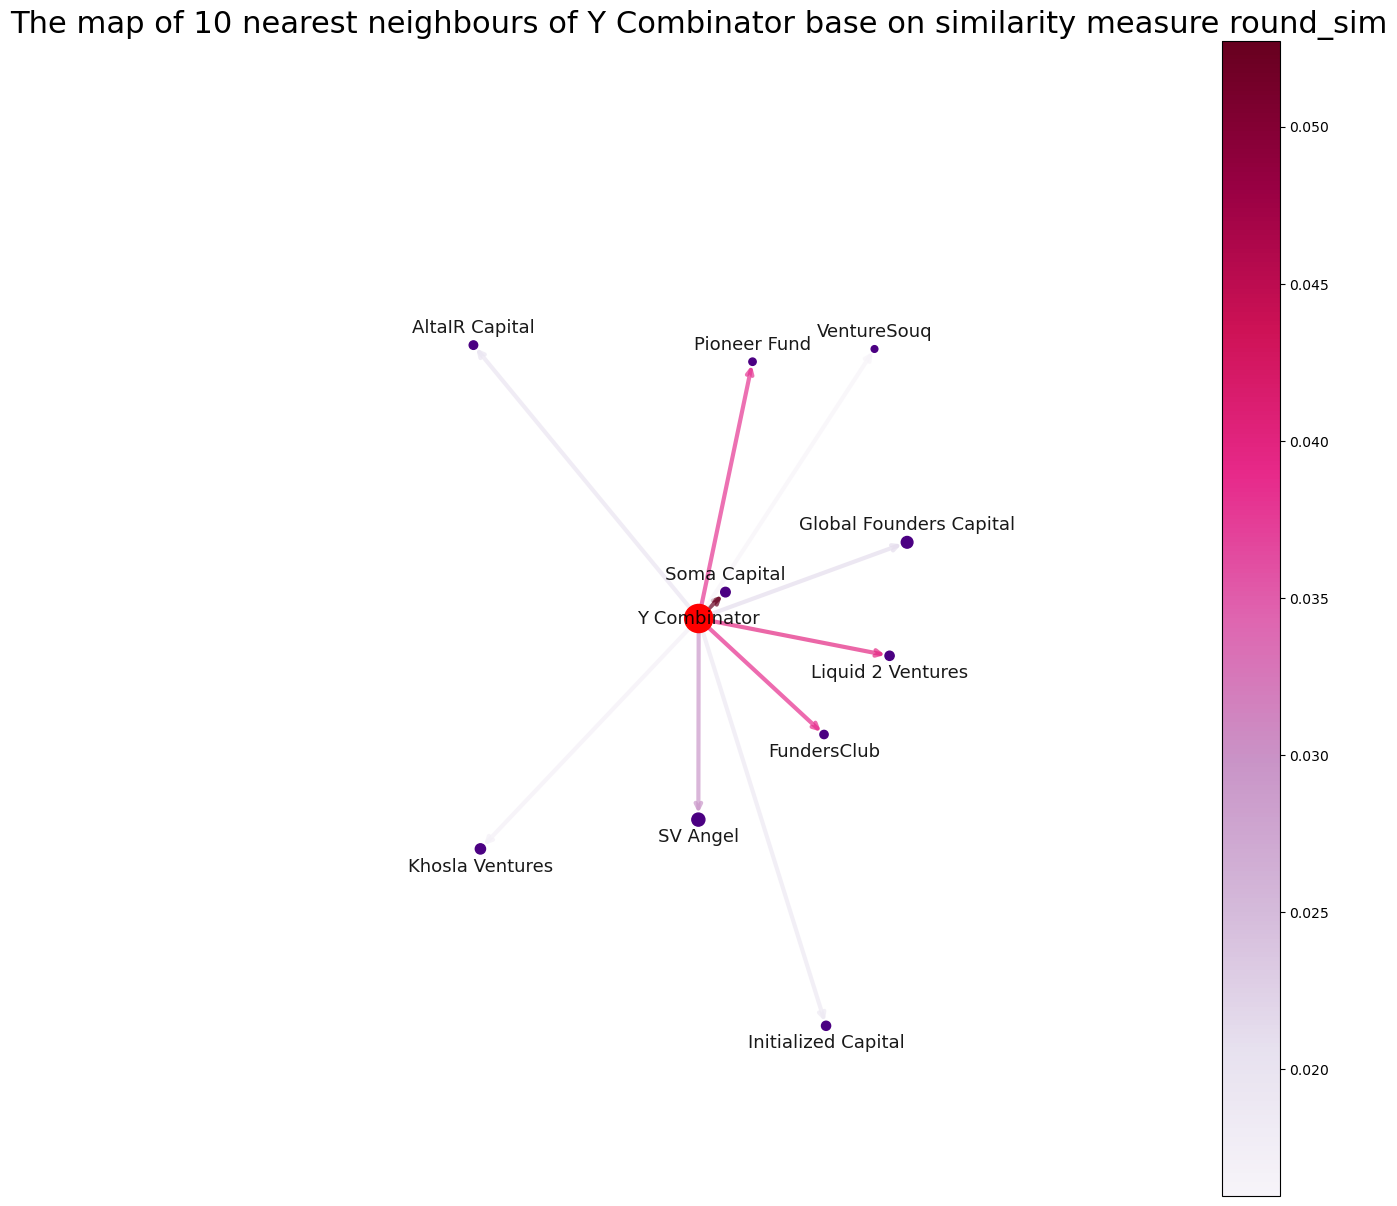

In [859]:
A_dist = plot_n_nearest_neighbours("Y Combinator", sequence_of_investments="any", similarity="round_sim", time_scale="5Y", save=True)

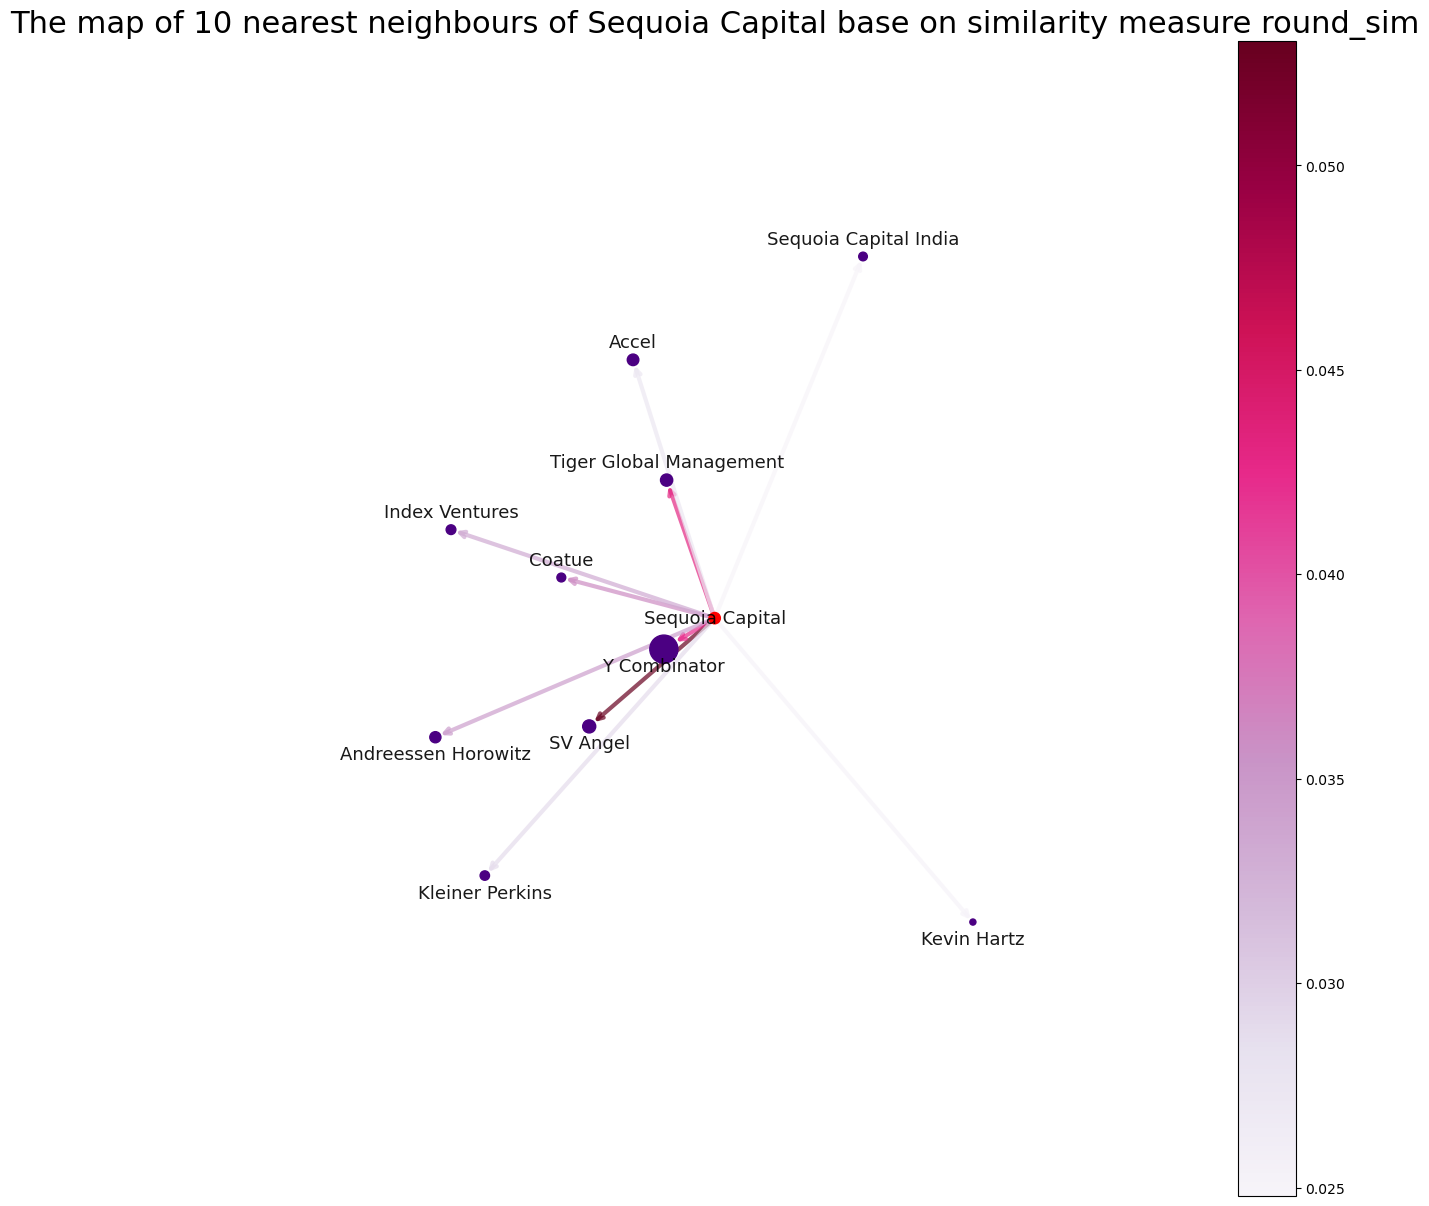

In [851]:
_ = plot_n_nearest_neighbours("Sequoia Capital", sequence_of_investments="any", similarity="round_sim", time_scale="5Y", save=True)

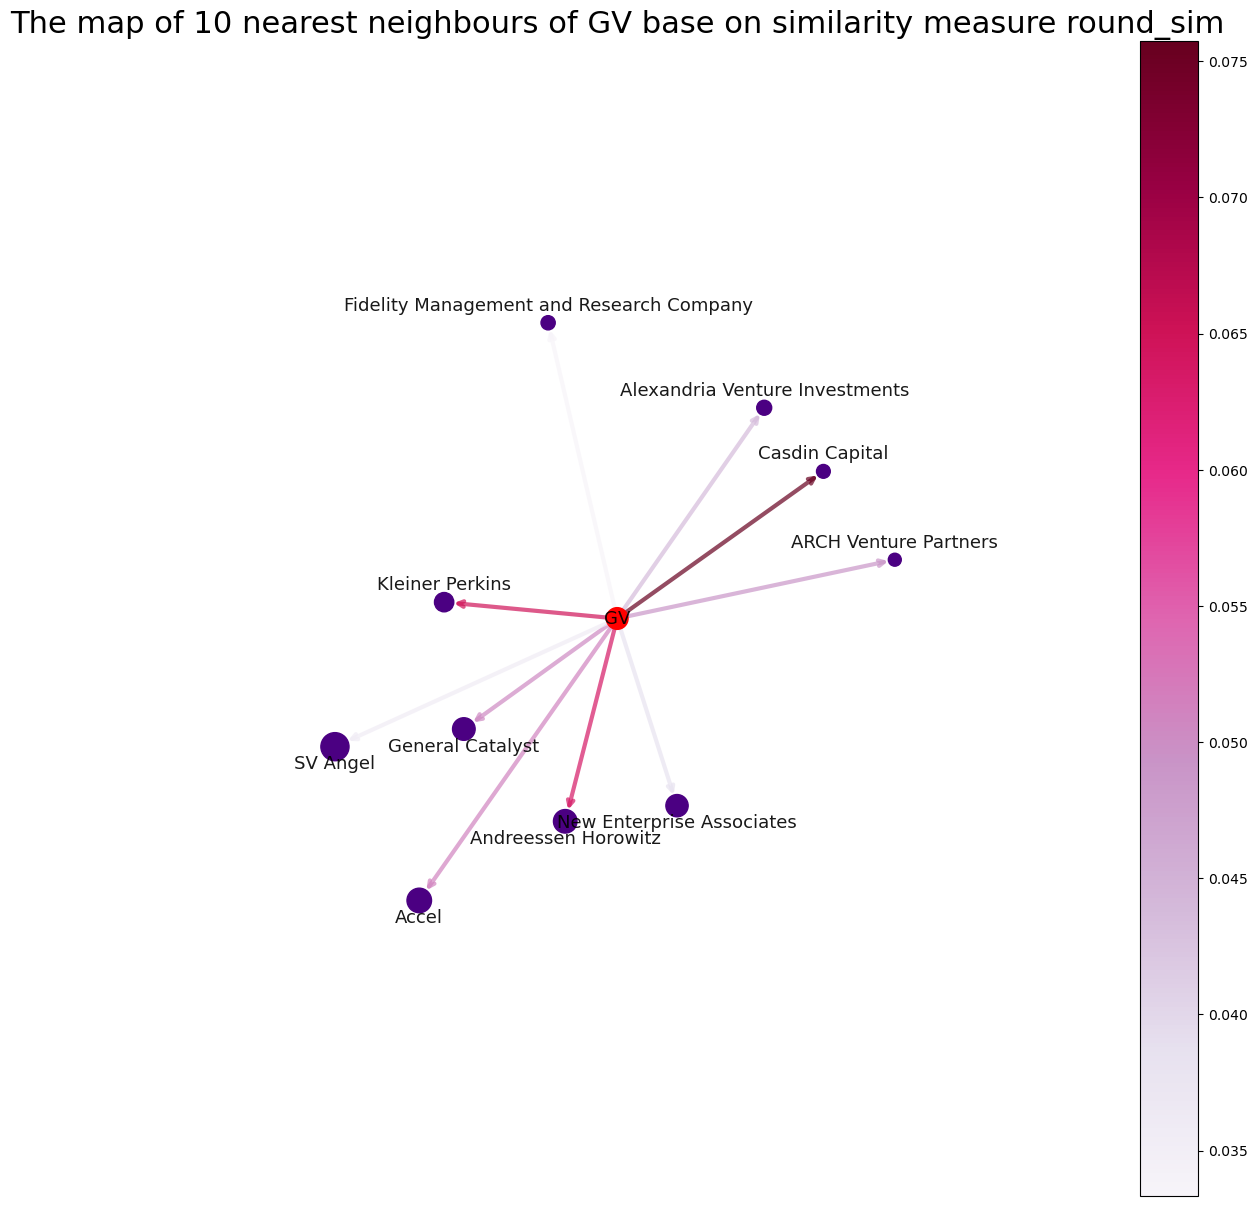

In [858]:
_ = plot_n_nearest_neighbours("GV", sequence_of_investments="any", similarity="round_sim", time_scale="5Y", save=True)